In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr

In [8]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

In [19]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_10704\464007337.py:25: RuntimeWarning: divide by zero encountered in divide
  ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_10704\464007337.py:25: RuntimeWarning: invalid value encountered in log10
  ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_10704\464007337.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


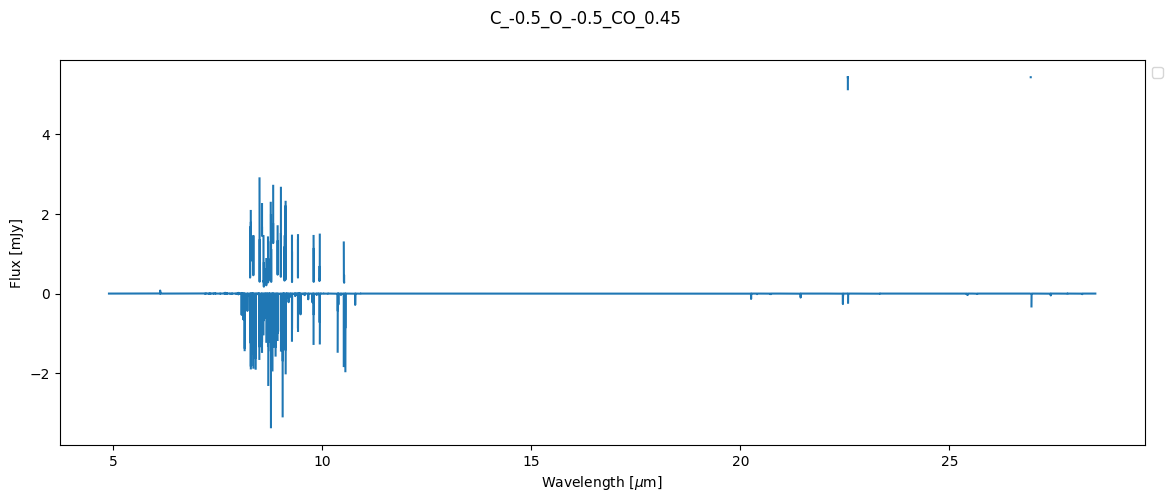

In [41]:
# %matplotlib notebook
plt.close('all')
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(14, 5))
species = ['atomic','C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
# species = ['atomic', 'CH4',  'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species =['CH4']
model = df['Model Name'][0]
FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
for index, specie in enumerate(species):
    specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    # new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    # if total_spec is None:
    #     total_spec = new_specie_flux
    # else:
    #     total_spec += new_specie_flux
    # ax.fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
    #                 color=cmap(index / len(species)))
    # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
    #                 color=cmap(index / len(species)))
    new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
    ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
    # ax.plot(FLiTs_wl, new_flux*1000)
# ax.plot(FLiTs_wl, FLiTs_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
specie = 'CO'
specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
# ax.plot(specie_wl, specie_flux)
# ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
fig.suptitle(model)
ax.set_ylabel('Flux [mJy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
# ax.set_xlim([6.1, 6.15])
# ax.set_ylim(0,0.5)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'Spectrum{model}.png')
plt.show()

6.125, 11.8

        atomic   CH4    CO   CO2   H2O   HCN   NH3    NO    O2    OH
atomic    1.00  0.06  0.32 -0.24 -0.04  0.15 -0.04 -0.07 -0.11 -0.07
CH4       0.06  1.00  0.02 -0.47 -0.75  0.74 -0.67 -0.83 -0.68 -0.89
CO        0.32  0.02  1.00 -0.21  0.00  0.05 -0.24  0.01  0.06  0.04
CO2      -0.24 -0.47 -0.21  1.00  0.64 -0.73  0.17  0.57  0.67  0.55
H2O      -0.04 -0.75  0.00  0.64  1.00 -0.88  0.47  0.89  0.81  0.84
HCN       0.15  0.74  0.05 -0.73 -0.88  1.00 -0.41 -0.84 -0.90 -0.81
NH3      -0.04 -0.67 -0.24  0.17  0.47 -0.41  1.00  0.53  0.36  0.60
NO       -0.07 -0.83  0.01  0.57  0.89 -0.84  0.53  1.00  0.79  0.92
O2       -0.11 -0.68  0.06  0.67  0.81 -0.90  0.36  0.79  1.00  0.76
OH       -0.07 -0.89  0.04  0.55  0.84 -0.81  0.60  0.92  0.76  1.00


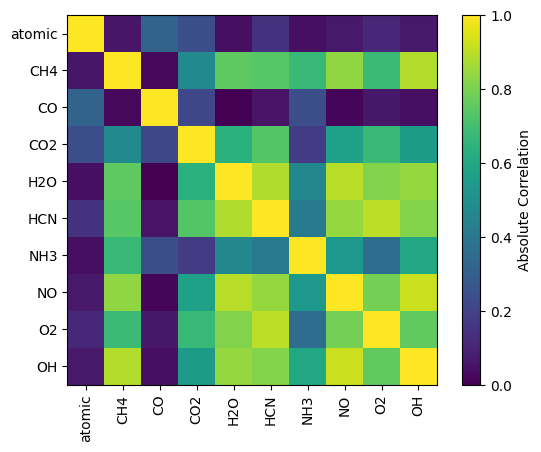

In [24]:
data = []
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)
print(df_FLiTs_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_FLiTs_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.yticks(ticks=np.arange(len(species)), labels=species)
plt.colorbar(label='Absolute Correlation')
plt.show()

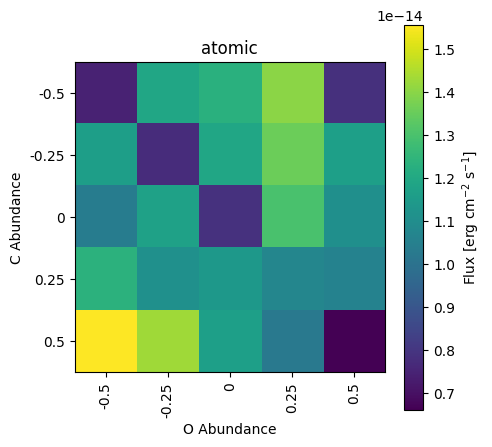

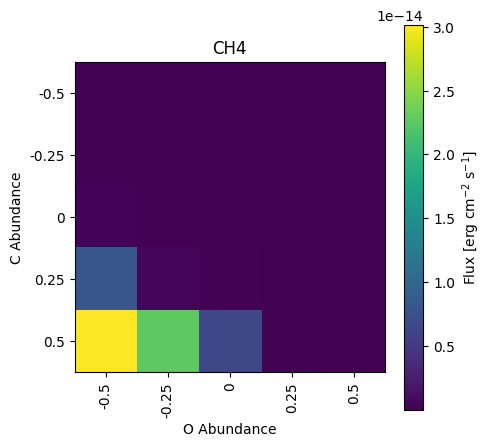

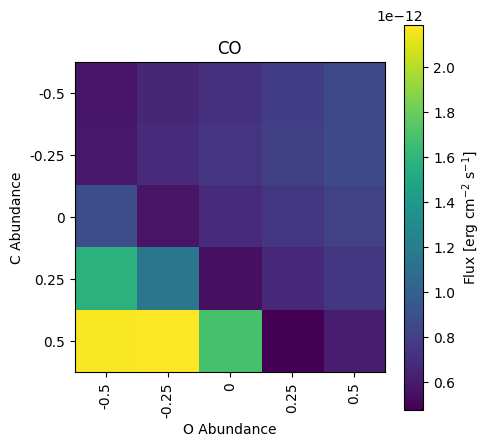

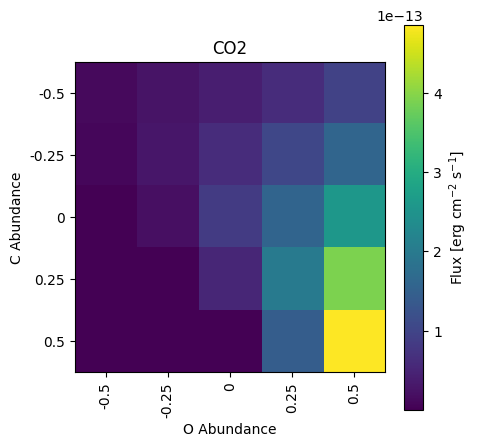

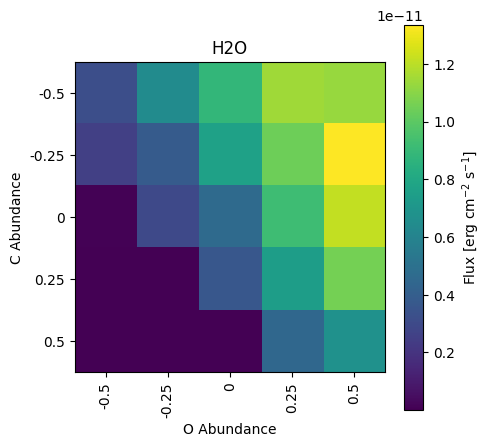

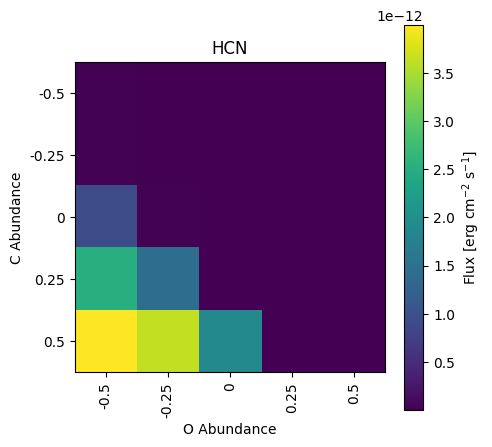

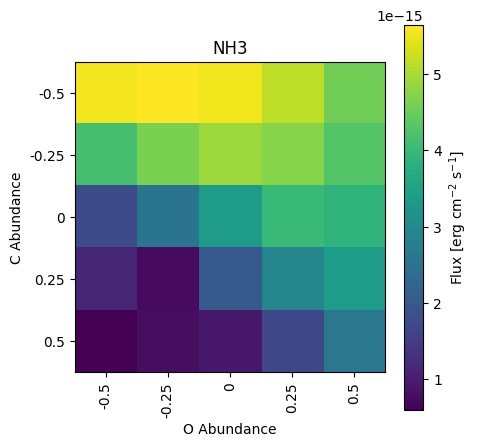

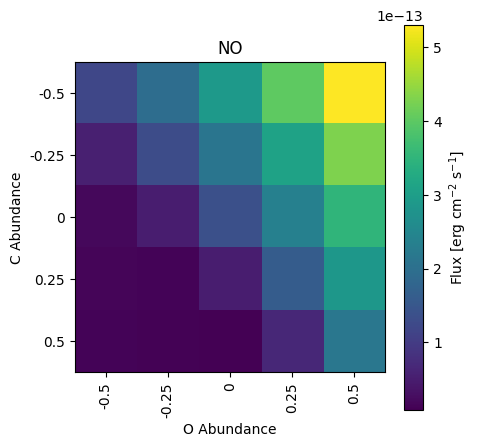

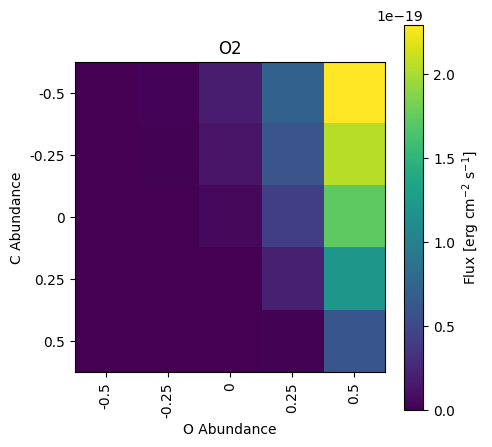

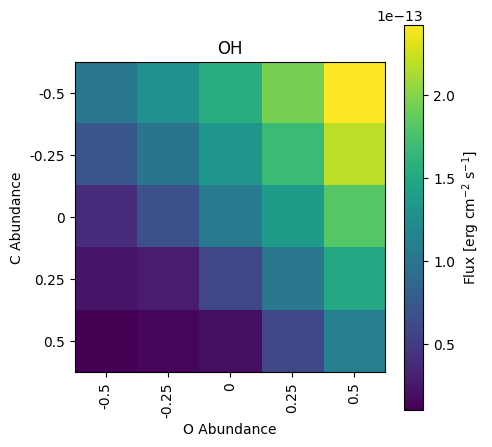

In [25]:

for specie in species:
    plt.figure(figsize=(5, 5))
    plt.imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    # plt.savefig(f'Flux_{specie}.png')
    plt.show()